# 🔊 AUDIO: Understanding and Generating Speech

tbd: introduction, pictures, problem statement

In [1]:
# Uncomment the following to make the run in Google Colab
# !pip -q install --upgrade transformers accelerate torchaudio librosa soundfile gradio TTS==0.22.0
# !apt -qq -y install ffmpeg

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from scripts.helpers import ensure_wav_16k_mono

def convert_to_wav(ind: int):
    in_path = ds.iloc[ind]["audio_path"]
    out_16k_path = f"wavs/audio_{ind}.wav"
    ensure_wav_16k_mono(in_path, out_16k_path)

## How to load audio samples

In [4]:
from scripts.load_common_voice import CommonVoiceDataset

dataset = CommonVoiceDataset()
# BASE_DIR = "/content/common_voice_sr"  # Default path for Colab
BASE_DIR = "/Users/msaidov/Microsoft/vocoder_data/common_voice/cv-corpus-22.0-delta-2025-06-20/sr"

ds = dataset.load_dataset(BASE_DIR)

Found 20 audio files


In [6]:
ind = 0
convert_to_wav(ind)
dataset.play(ind)

[0] common_voice_sr_43196828.mp3


In [5]:
ind = 2
convert_to_wav(ind)
dataset.play(ind)

[2] common_voice_sr_43196829.mp3


In [6]:
ind = 15
convert_to_wav(ind)
dataset.play(ind)

[15] common_voice_sr_43194598.mp3


## Automatic Speech Recognition with Whisper

In [7]:
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline as hf_pipeline

# TODO: switch the model to the Colab path
whisper_path = "/Users/msaidov/models/huggingface/whisper-small"

asr_model = AutoModelForSpeechSeq2Seq.from_pretrained(
    whisper_path,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    low_cpu_mem_usage=True,
    use_safetensors=True,
)
asr_model.to(device)
asr_processor = AutoProcessor.from_pretrained(whisper_path)

asr_pipe = hf_pipeline(
    task="automatic-speech-recognition",
    model=asr_model,
    tokenizer=asr_processor.tokenizer,
    feature_extractor=asr_processor.feature_extractor,
    device=0 if device == "cuda" else -1,
)

generate_kwargs = {"language": "sr", "task": "transcribe"}

Device set to use cpu


Let's test them on the several dataset samples:

In [8]:
wav_path = f'wavs/audio_0.wav'
asr_pipe(wav_path, generate_kwargs=generate_kwargs, return_timestamps=False)

`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.


{'text': ' koji su bili glavni ospesi?'}

In [9]:
wav_path = f'wavs/audio_2.wav'
asr_pipe(wav_path, generate_kwargs=generate_kwargs, return_timestamps=False)

{'text': ' I na kraju imamo zadatak da promjenimo ponashanje.'}

In [10]:
wav_path = f'wavs/audio_15.wav'
asr_pipe(wav_path, generate_kwargs=generate_kwargs, return_timestamps=False)

{'text': ' Nema, izveš to ja o povredjenima.'}

## Neural Machine Translation with OPUS-MT

In [9]:
from scripts.helpers import load_opus

# TODO: switch the model to the Google Colab path
opus_path = "/Users/msaidov/models/huggingface/opus-mt-tc-big-sh-en"


def translate(text: str, max_new_tokens: int = 256, device: str = "cpu") -> str:
    tok, mdl = load_opus(opus_path, device=device)
    inputs = tok(text, return_tensors="pt").to(device)
    with torch.inference_mode():
        out = mdl.generate(**inputs, max_new_tokens=max_new_tokens)
    return tok.batch_decode(out, skip_special_tokens=True)[0]

In [10]:
text_0 = "koji su bili glavni ospesi?"
translate(text_0)

'What were the main goals?'

In [13]:
text_2 = "I na kraju imamo zadatak da promjenimo ponashanje."
translate(text_2)

'And in the end, we have the task of changing our behavior.'

In [14]:
text_15 = "Nema, izveš to ja o povredjenima."
translate(text_15)

"No, I'll tell you about the injured."

## Voice Cloning + Text-to-Speech with Coqui XTTS v2

In [5]:
from TTS.api import TTS

# TODO: switch the model to the Google Colab path
xtts_model_name = "tts_models/multilingual/multi-dataset/xtts_v2"

tts = TTS(xtts_model_name)
tts.to(device)
print("TTS model is loaded!")

TTS model is loaded!


In [10]:
wav_path = f'wavs/audio_0.wav'
text_0 = 'What were the main goals?'
out_wav = "wavs/audio_0_en.wav"

tts.tts_to_file(
    text=text_0,
    speaker_wav=wav_path,
    language="en",
    file_path=out_wav,
)

'wavs/audio_0_en.wav'

In [12]:
wav_path = f'wavs/audio_2.wav'
text_2 = 'And in the end, we have the task of changing our behavior.'
out_wav = "wavs/audio_2_en.wav"

tts.tts_to_file(
    text=text_2,
    speaker_wav=wav_path,
    language="en",
    file_path=out_wav,
)

'wavs/audio_2_en.wav'

In [6]:
wav_path = f'wavs/audio_15.wav'
text_15 = "No, I'll tell you about the injured."
out_wav = "wavs/audio_15_en.wav"

tts.tts_to_file(
    text=text_15,
    speaker_wav=wav_path,
    language="en",
    file_path=out_wav,
)

'wavs/audio_15_en.wav'

## Combining to the end-to-end Speech-to-Speech system

In [36]:
import os
import re
import tempfile
import librosa
import gradio as gr
import soundfile as sf
from IPython.display import display, Audio


def ensure_wav_16k_mono_safe(in_path: str) -> str:
    tmpdir = tempfile.mkdtemp(prefix="s2s_")
    base = os.path.basename(in_path)
    out_path = os.path.join(tmpdir, f"{os.path.splitext(base)[0]}_16k.wav")
    wav, sr = librosa.load(in_path, sr=16000, mono=True)
    sf.write(out_path, wav, 16000)
    return out_path


def _clean_path(p: str | None) -> str | None:
    if p is None:
        return None
    p = re.sub(r'[\x00\r\n]+', '', p).strip()
    return p or None


def resolve_output_path(user_out: str | None, default_fname: str = "xtts_en.wav") -> str:
    p = _clean_path(user_out)
    if not p:
        out_dir = tempfile.mkdtemp(prefix="s2s_")
        return os.path.join(out_dir, default_fname)
    p = os.path.expanduser(p)
    if p.endswith(os.sep) or os.path.isdir(p):
        os.makedirs(p, exist_ok=True)
        return os.path.join(p, default_fname)
    parent = os.path.dirname(p) or "."
    os.makedirs(parent, exist_ok=True)
    return p


def s2s_pipeline(input_audio, output_audio):
    if not input_audio:
        return "No audio.", "", None

    in_path = input_audio if isinstance(input_audio, str) else input_audio.name
    norm_wav = ensure_wav_16k_mono_safe(in_path)
    asr_res = asr_pipe(norm_wav, generate_kwargs=generate_kwargs, return_timestamps=False)
    nmt_src_text = asr_res["text"].strip()
    nmt_trg_text = translate(nmt_src_text)
    out_wav = resolve_output_path(output_audio)
    tts.tts_to_file(
        text=nmt_trg_text,
        speaker_wav=norm_wav,
        language="en",
        file_path=out_wav,
    )
    return nmt_src_text, nmt_trg_text, out_wav

In [37]:
import gradio as gr

with gr.Blocks(title="Speech→Speech: Serbian → English") as demo:
    gr.Markdown("## 🎤 Serbian → English (Whisper + OPUS‑MT + XTTS v2)\n"
                "Upload/record Serbian speech → ASR (sr) → NMT (sr→en) → TTS (en, cloned voice).")

    with gr.Row():
        audio_in = gr.Audio(sources=["upload","microphone"], type="filepath",
                            label="Input audio (Serbian, WAV recommended)")
        out_path = gr.Textbox(value="", placeholder="(optional) /path/to/output.wav or a directory",
                              label="Output WAV path (optional)")

    run_btn  = gr.Button("Translate & Speak")

    with gr.Row():
        asr_out = gr.Textbox(label="ASR (Serbian text)")
        nmt_out = gr.Textbox(label="NMT (English text)")
    audio_out = gr.Audio(label="Synthesized English (cloned voice)")

    run_btn.click(fn=s2s_pipeline,
                  inputs=[audio_in, out_path],
                  outputs=[asr_out, nmt_out, audio_out])

demo.launch(debug=False, share=False)

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


## Note: Omni-modal models

**Idea**: if the model is able to process ASR, translation and TTS itself, that can be promising from the quality standpoint compared to the pipeline with 3 independent parts.

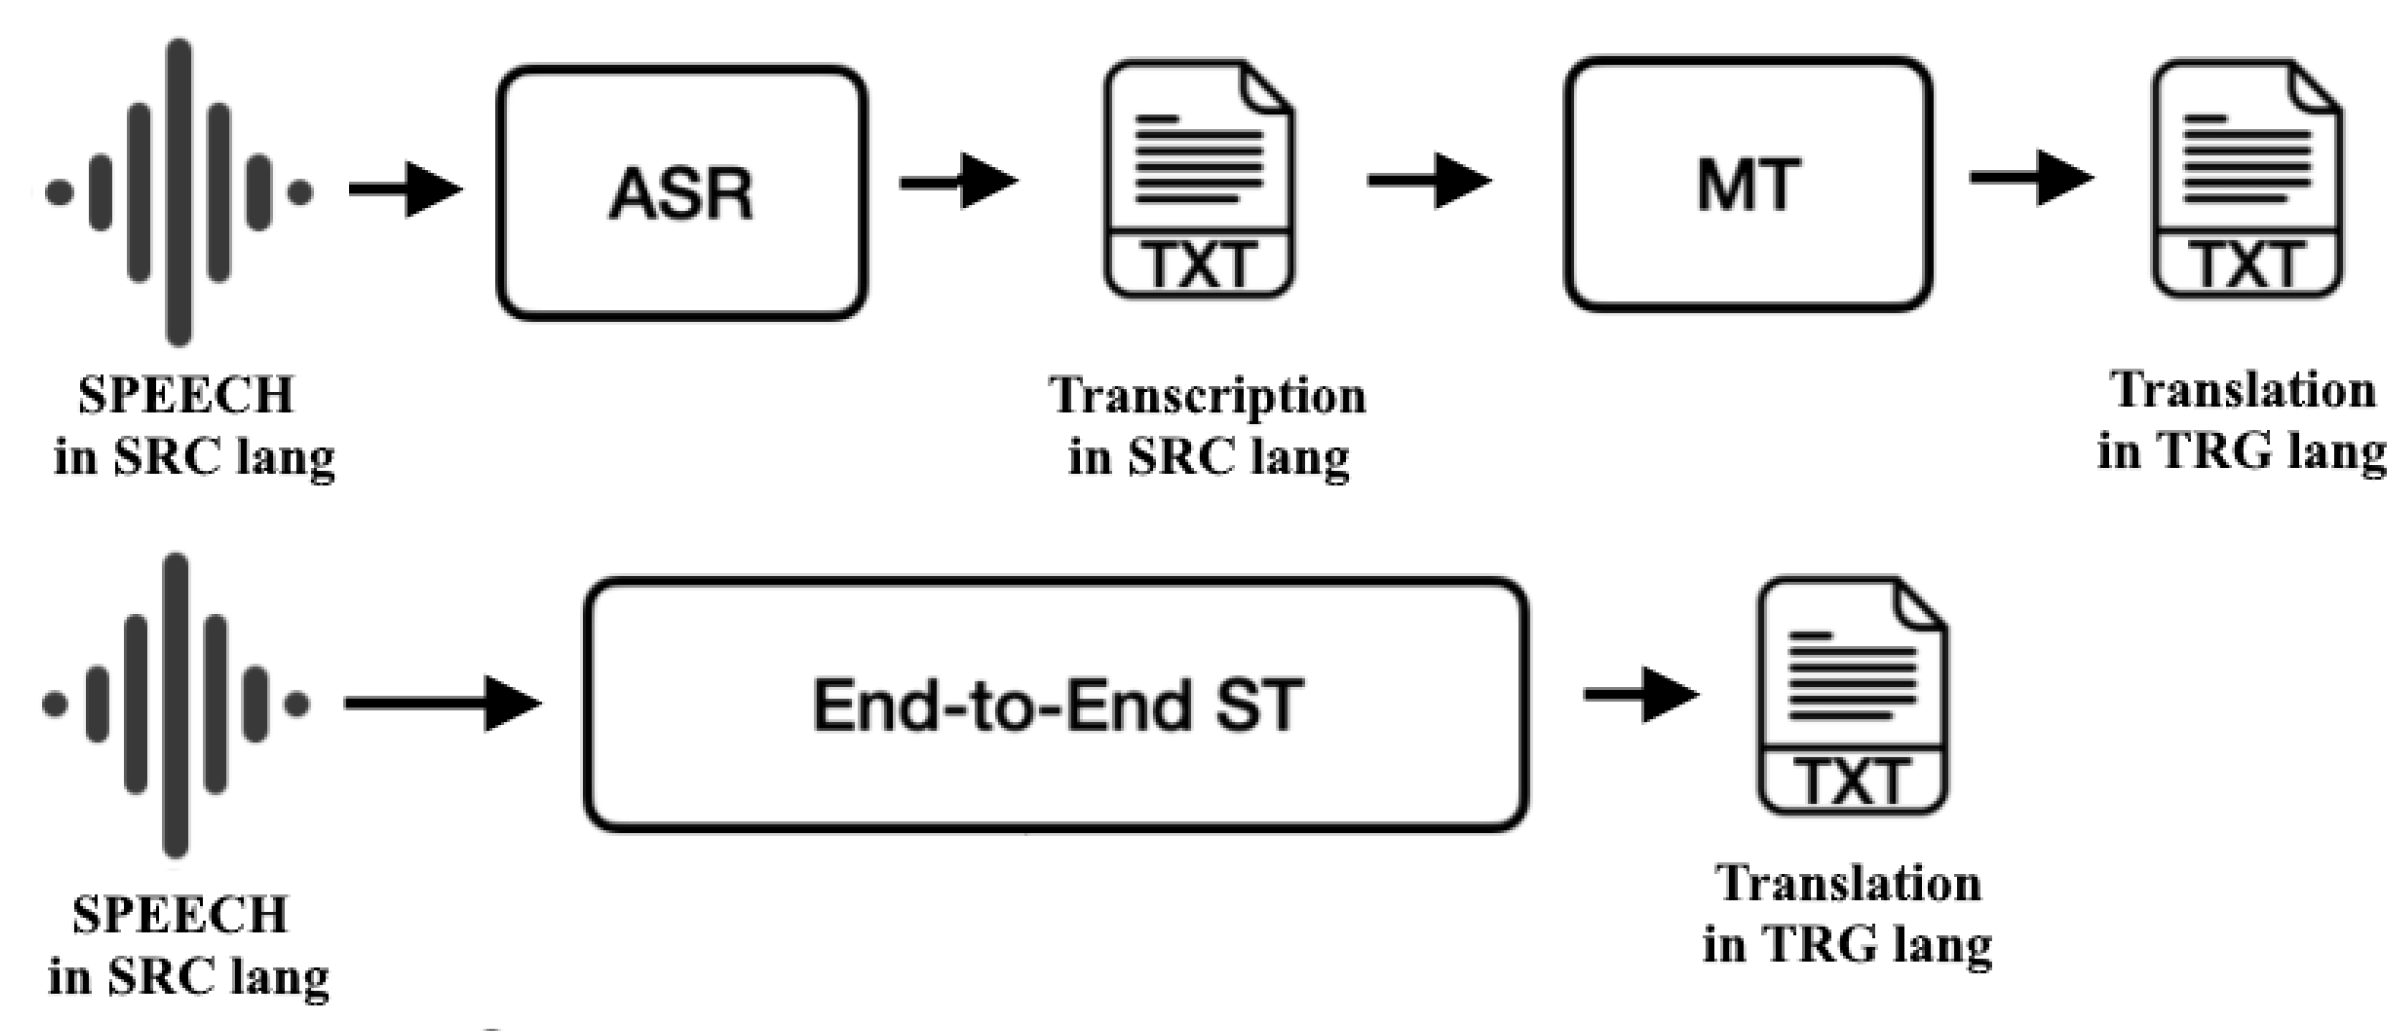